In [1]:
pip install transformers

#Import Library

In [24]:
import torch
from transformers import ResNetForImageClassification
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets.voc as voc
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import average_precision_score, accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Config

In [3]:
n_epochs = 20
learning_rate = 0.001
patience = 3
momentum = 0.9
weight_decay = 1e-4
batch_size = 32

# Dataset

## Class Pascal VOC Dataset

In [4]:
class PascalVOC_Dataset(voc.VOCDetection):
    def __init__(self, root, year='2007', image_set='train', download=True, transform=None, target_transform=None):
        super().__init__( root,
                          year=year,
                          image_set=image_set,
                          download=download,
                          transform=transform,
                          target_transform=target_transform)

    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return len(self.images)

def encode_labels(target):
    ls = target['annotation']['object']

    j = []
    if type(ls) == dict:
        if int(ls['difficult']) == 0:
            j.append(object_categories.index(ls['name']))

    else:
        for i in range(len(ls)):
            if int(ls[i]['difficult']) == 0:
                j.append(object_categories.index(ls[i]['name']))

    k = np.zeros(len(object_categories))
    k[j] = 1

    return torch.from_numpy(k)

In [5]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                          std = [ 0.229, 0.224, 0.225 ]),
])

## Download data

In [6]:
dataset_train = PascalVOC_Dataset(root = "./data_train",
                                  year='2007',
                                  image_set='train',
                                  download=True,
                                  transform=transform,
                                  target_transform=encode_labels)

dataset_valid = PascalVOC_Dataset(root = "./data_val",
                                  year='2007',
                                  image_set='val',
                                  download=True,
                                  transform=transform,
                                  target_transform=encode_labels)

dataset_test = PascalVOC_Dataset(root = "./data_test",
                                      year='2007',
                                      image_set='test',
                                      download=True,
                                      transform=transform,
                                      target_transform=encode_labels)

100%|██████████| 460032000/460032000 [00:47<00:00, 9669937.53it/s] 


Extracting ./data_train/VOCtrainval_06-Nov-2007.tar to ./data_train


100%|██████████| 460032000/460032000 [00:26<00:00, 17599933.14it/s]


Extracting ./data_val/VOCtrainval_06-Nov-2007.tar to ./data_val


100%|██████████| 451020800/451020800 [00:26<00:00, 16813471.33it/s]


Extracting ./data_test/VOCtest_06-Nov-2007.tar to ./data_test


## DataLoader

In [7]:
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [8]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
image = images[0]
labels.shape

torch.Size([32, 20])

In [9]:
image.shape

torch.Size([3, 300, 300])

# Evaluation

In [10]:
def get_ap_score(y_true, y_scores):
    ap_scores = []

    for i in range(y_true.shape[0]):
        ap_scores.append(average_precision_score(y_true=y_true[i], y_score=y_scores[i]))

    return sum(ap_scores) / len(ap_scores)

## EarlyStopping

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# Model

In [12]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes = 20):
        super(ResNetClassifier, self).__init__()

        self.resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

        for param in self.resnet.parameters():
            param.requires_grad = False

        in_features = self.resnet.classifier[-1].in_features
        new_classifier = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features, 256),
            nn.Linear(256, num_classes)
        )
        self.resnet.classifier = new_classifier

    def forward(self, x):
        logits = self.resnet(x).logits
        return logits

# Training

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNetClassifier().to(device)

criterion = nn.BCEWithLogitsLoss(reduction='sum')

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

early_stopping = EarlyStopping(patience = patience, verbose=True)
scheduler = StepLR(optimizer, step_size = 5, gamma = 0.1)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [14]:
list_loss = []
list_ap = []
list_f1 = []
list_dev_loss = []
list_dev_ap = []
list_dev_f1 = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    epoch_ap = 0.0
    epoch_f1 = 0.0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    for i, (images, labels) in pbar:
        labels = labels.float()
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels)

        ap_score = get_ap_score(torch.Tensor.cpu(labels).detach().numpy(), torch.Tensor.cpu(torch.sigmoid(output)).detach().numpy())
        f1 = f1_score(torch.Tensor.cpu(labels).detach().numpy(), (torch.sigmoid(output).cpu().detach().numpy() > 0.5), average="micro")

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_ap += ap_score
        epoch_f1 += f1
        pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss / (i+1):.4f}, mAP: {epoch_ap / (i+1):.4f}, F1 Score: {epoch_f1 / (i+1):.4f}')

    # Step the learning rate scheduler
    scheduler.step()

    epoch_loss /= len(train_loader)
    epoch_ap /= len(train_loader)
    epoch_f1 /= len(train_loader)
    list_loss.append(epoch_loss)
    list_ap.append(epoch_ap)
    list_f1.append(epoch_f1)

    dev_loss = 0.0
    dev_ap = 0.0
    dev_f1 = 0.0

    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            labels = labels.to(float)
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            ap_score = get_ap_score(torch.Tensor.cpu(labels).detach().numpy(), torch.Tensor.cpu(torch.sigmoid(outputs)).detach().numpy())
            f1 = f1_score(torch.Tensor.cpu(labels).detach().numpy(), (torch.sigmoid(outputs).cpu().detach().numpy() > 0.5), average="micro")

            dev_loss += loss.item()
            dev_ap += ap_score
            dev_f1 += f1

    dev_loss /= len(valid_loader)
    dev_ap /= len(valid_loader)
    dev_f1 /= len(valid_loader)

    list_dev_loss.append(dev_loss)
    list_dev_ap.append(dev_ap)
    list_dev_f1.append(dev_f1)
    print(f"Epoch {epoch+1}/{n_epochs} | Training Loss: {epoch_loss:.6f} | Val Loss: {dev_loss:.6f} | Val mAP: {dev_ap:.4f}, | Val F1 Score: {dev_f1:.4f}")

    early_stopping(dev_loss, model)
    if early_stopping.early_stop:
        n_epochs = epoch + 1
        print("Early stopping")
        break

Epoch [1/20], Loss: 148.4483, mAP: 0.5709, F1 Score: 0.2532: 100%|██████████| 79/79 [00:46<00:00,  1.68it/s]


Epoch 1/20 | Training Loss: 148.448305 | Val Loss: 101.694629 | Val mAP: 0.7924, | Val F1 Score: 0.4316
Validation loss decreased (inf --> 101.694629).  Saving model ...


Epoch [2/20], Loss: 81.0461, mAP: 0.8389, F1 Score: 0.5921: 100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 2/20 | Training Loss: 81.046064 | Val Loss: 69.568918 | Val mAP: 0.8627, | Val F1 Score: 0.6783
Validation loss decreased (101.694629 --> 69.568918).  Saving model ...


Epoch [3/20], Loss: 59.5684, mAP: 0.9063, F1 Score: 0.7379: 100%|██████████| 79/79 [00:32<00:00,  2.46it/s]


Epoch 3/20 | Training Loss: 59.568436 | Val Loss: 56.503253 | Val mAP: 0.9063, | Val F1 Score: 0.7519
Validation loss decreased (69.568918 --> 56.503253).  Saving model ...


Epoch [4/20], Loss: 48.3082, mAP: 0.9352, F1 Score: 0.7929: 100%|██████████| 79/79 [00:32<00:00,  2.46it/s]


Epoch 4/20 | Training Loss: 48.308170 | Val Loss: 50.646906 | Val mAP: 0.9283, | Val F1 Score: 0.7679
Validation loss decreased (56.503253 --> 50.646906).  Saving model ...


Epoch [5/20], Loss: 41.2912, mAP: 0.9510, F1 Score: 0.8330: 100%|██████████| 79/79 [00:32<00:00,  2.46it/s]


Epoch 5/20 | Training Loss: 41.291245 | Val Loss: 46.594232 | Val mAP: 0.9295, | Val F1 Score: 0.7967
Validation loss decreased (50.646906 --> 46.594232).  Saving model ...


Epoch [6/20], Loss: 36.3414, mAP: 0.9600, F1 Score: 0.8531: 100%|██████████| 79/79 [00:35<00:00,  2.21it/s]


Epoch 6/20 | Training Loss: 36.341431 | Val Loss: 44.495689 | Val mAP: 0.9361, | Val F1 Score: 0.8093
Validation loss decreased (46.594232 --> 44.495689).  Saving model ...


Epoch [7/20], Loss: 34.8200, mAP: 0.9656, F1 Score: 0.8572: 100%|██████████| 79/79 [00:35<00:00,  2.23it/s]


Epoch 7/20 | Training Loss: 34.819963 | Val Loss: 45.271995 | Val mAP: 0.9359, | Val F1 Score: 0.8060


Epoch [8/20], Loss: 34.9597, mAP: 0.9631, F1 Score: 0.8561: 100%|██████████| 79/79 [00:33<00:00,  2.37it/s]


Epoch 8/20 | Training Loss: 34.959680 | Val Loss: 43.682877 | Val mAP: 0.9374, | Val F1 Score: 0.8166
Validation loss decreased (44.495689 --> 43.682877).  Saving model ...


Epoch [9/20], Loss: 34.4953, mAP: 0.9666, F1 Score: 0.8574: 100%|██████████| 79/79 [00:32<00:00,  2.42it/s]


Epoch 9/20 | Training Loss: 34.495322 | Val Loss: 44.450322 | Val mAP: 0.9363, | Val F1 Score: 0.8147


Epoch [10/20], Loss: 33.7032, mAP: 0.9665, F1 Score: 0.8631: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Epoch 10/20 | Training Loss: 33.703223 | Val Loss: 44.136059 | Val mAP: 0.9366, | Val F1 Score: 0.8124


Epoch [11/20], Loss: 33.7739, mAP: 0.9683, F1 Score: 0.8624: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Epoch 11/20 | Training Loss: 33.773863 | Val Loss: 44.169269 | Val mAP: 0.9383, | Val F1 Score: 0.8109
Early stopping


# Test Model

In [15]:
model.eval()
y_true_all = []
y_pred_all = []
test_f1 = 0.0
test_ap = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.to(float)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        ap_score = get_ap_score(torch.Tensor.cpu(labels).detach().numpy(), torch.Tensor.cpu(torch.sigmoid(outputs)).detach().numpy())
        f1 = f1_score(torch.Tensor.cpu(labels).detach().numpy(), (torch.sigmoid(outputs).cpu().detach().numpy() > 0.5), average="micro")

        test_f1 += f1
        test_ap += ap_score
        y_true_all.extend(torch.Tensor.cpu(labels).detach().numpy())
        y_pred_all.extend(torch.sigmoid(outputs).cpu().detach().numpy() > 0.5)

test_f1 /= len(test_loader)
test_ap /= len(test_loader)
print(f"F1 Score: {test_f1:.4f} | mAP: {dev_ap:.4f}")

F1 Score: 0.8163 | mAP: 0.9383


In [31]:
print(classification_report(y_true_all, y_pred_all, target_names=object_categories, zero_division=0))

              precision    recall  f1-score   support

   aeroplane       1.00      0.87      0.93       204
     bicycle       0.96      0.76      0.85       239
        bird       0.98      0.80      0.88       282
        boat       0.94      0.78      0.86       172
      bottle       0.69      0.47      0.56       212
         bus       0.84      0.75      0.79       174
         car       0.90      0.84      0.87       721
         cat       0.97      0.84      0.90       322
       chair       0.69      0.45      0.55       417
         cow       0.84      0.50      0.63       127
 diningtable       0.80      0.52      0.63       190
         dog       0.95      0.72      0.82       418
       horse       0.96      0.85      0.90       274
   motorbike       0.94      0.81      0.87       222
      person       0.94      0.84      0.89      2007
 pottedplant       0.82      0.40      0.54       224
       sheep       0.91      0.49      0.64        97
        sofa       0.77    

## Plot

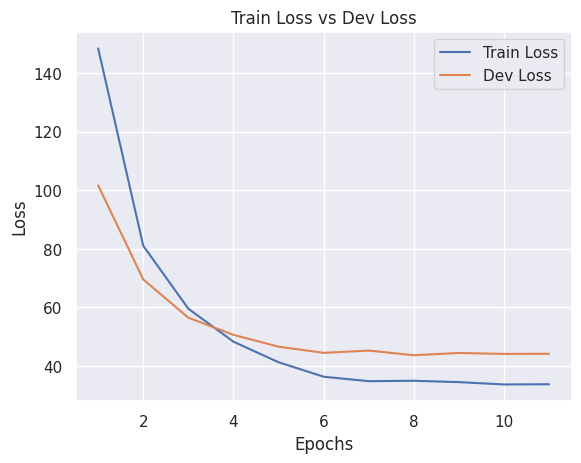

In [21]:
data = {
    "Epochs": list(range(1, n_epochs + 1)),
    "Train Loss": list_loss,
    "Train mAP": list_ap,
    "Dev Loss": list_dev_loss,
    "Dev mAP": list_dev_ap
}
df = pd.DataFrame(data)

sns.set(style="darkgrid")
sns.lineplot(data=df, x="Epochs", y="Train Loss", label="Train Loss")
sns.lineplot(data=df, x="Epochs", y="Dev Loss", label="Dev Loss")
plt.title('Train Loss vs Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

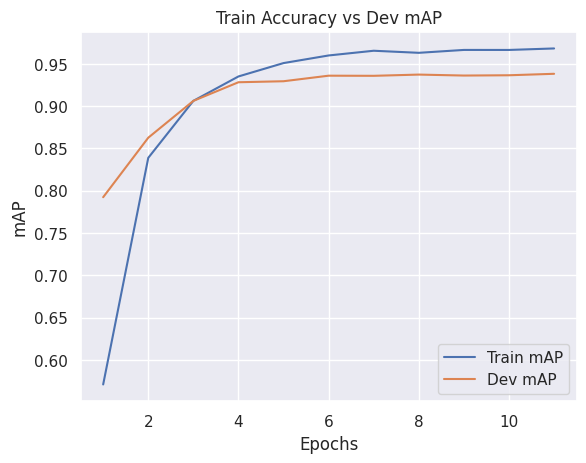

In [22]:
sns.lineplot(data=df, x="Epochs", y="Train mAP", label="Train mAP")
sns.lineplot(data=df, x="Epochs", y="Dev mAP", label="Dev mAP")
plt.title('Train Accuracy vs Dev mAP')
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.legend()
plt.show()

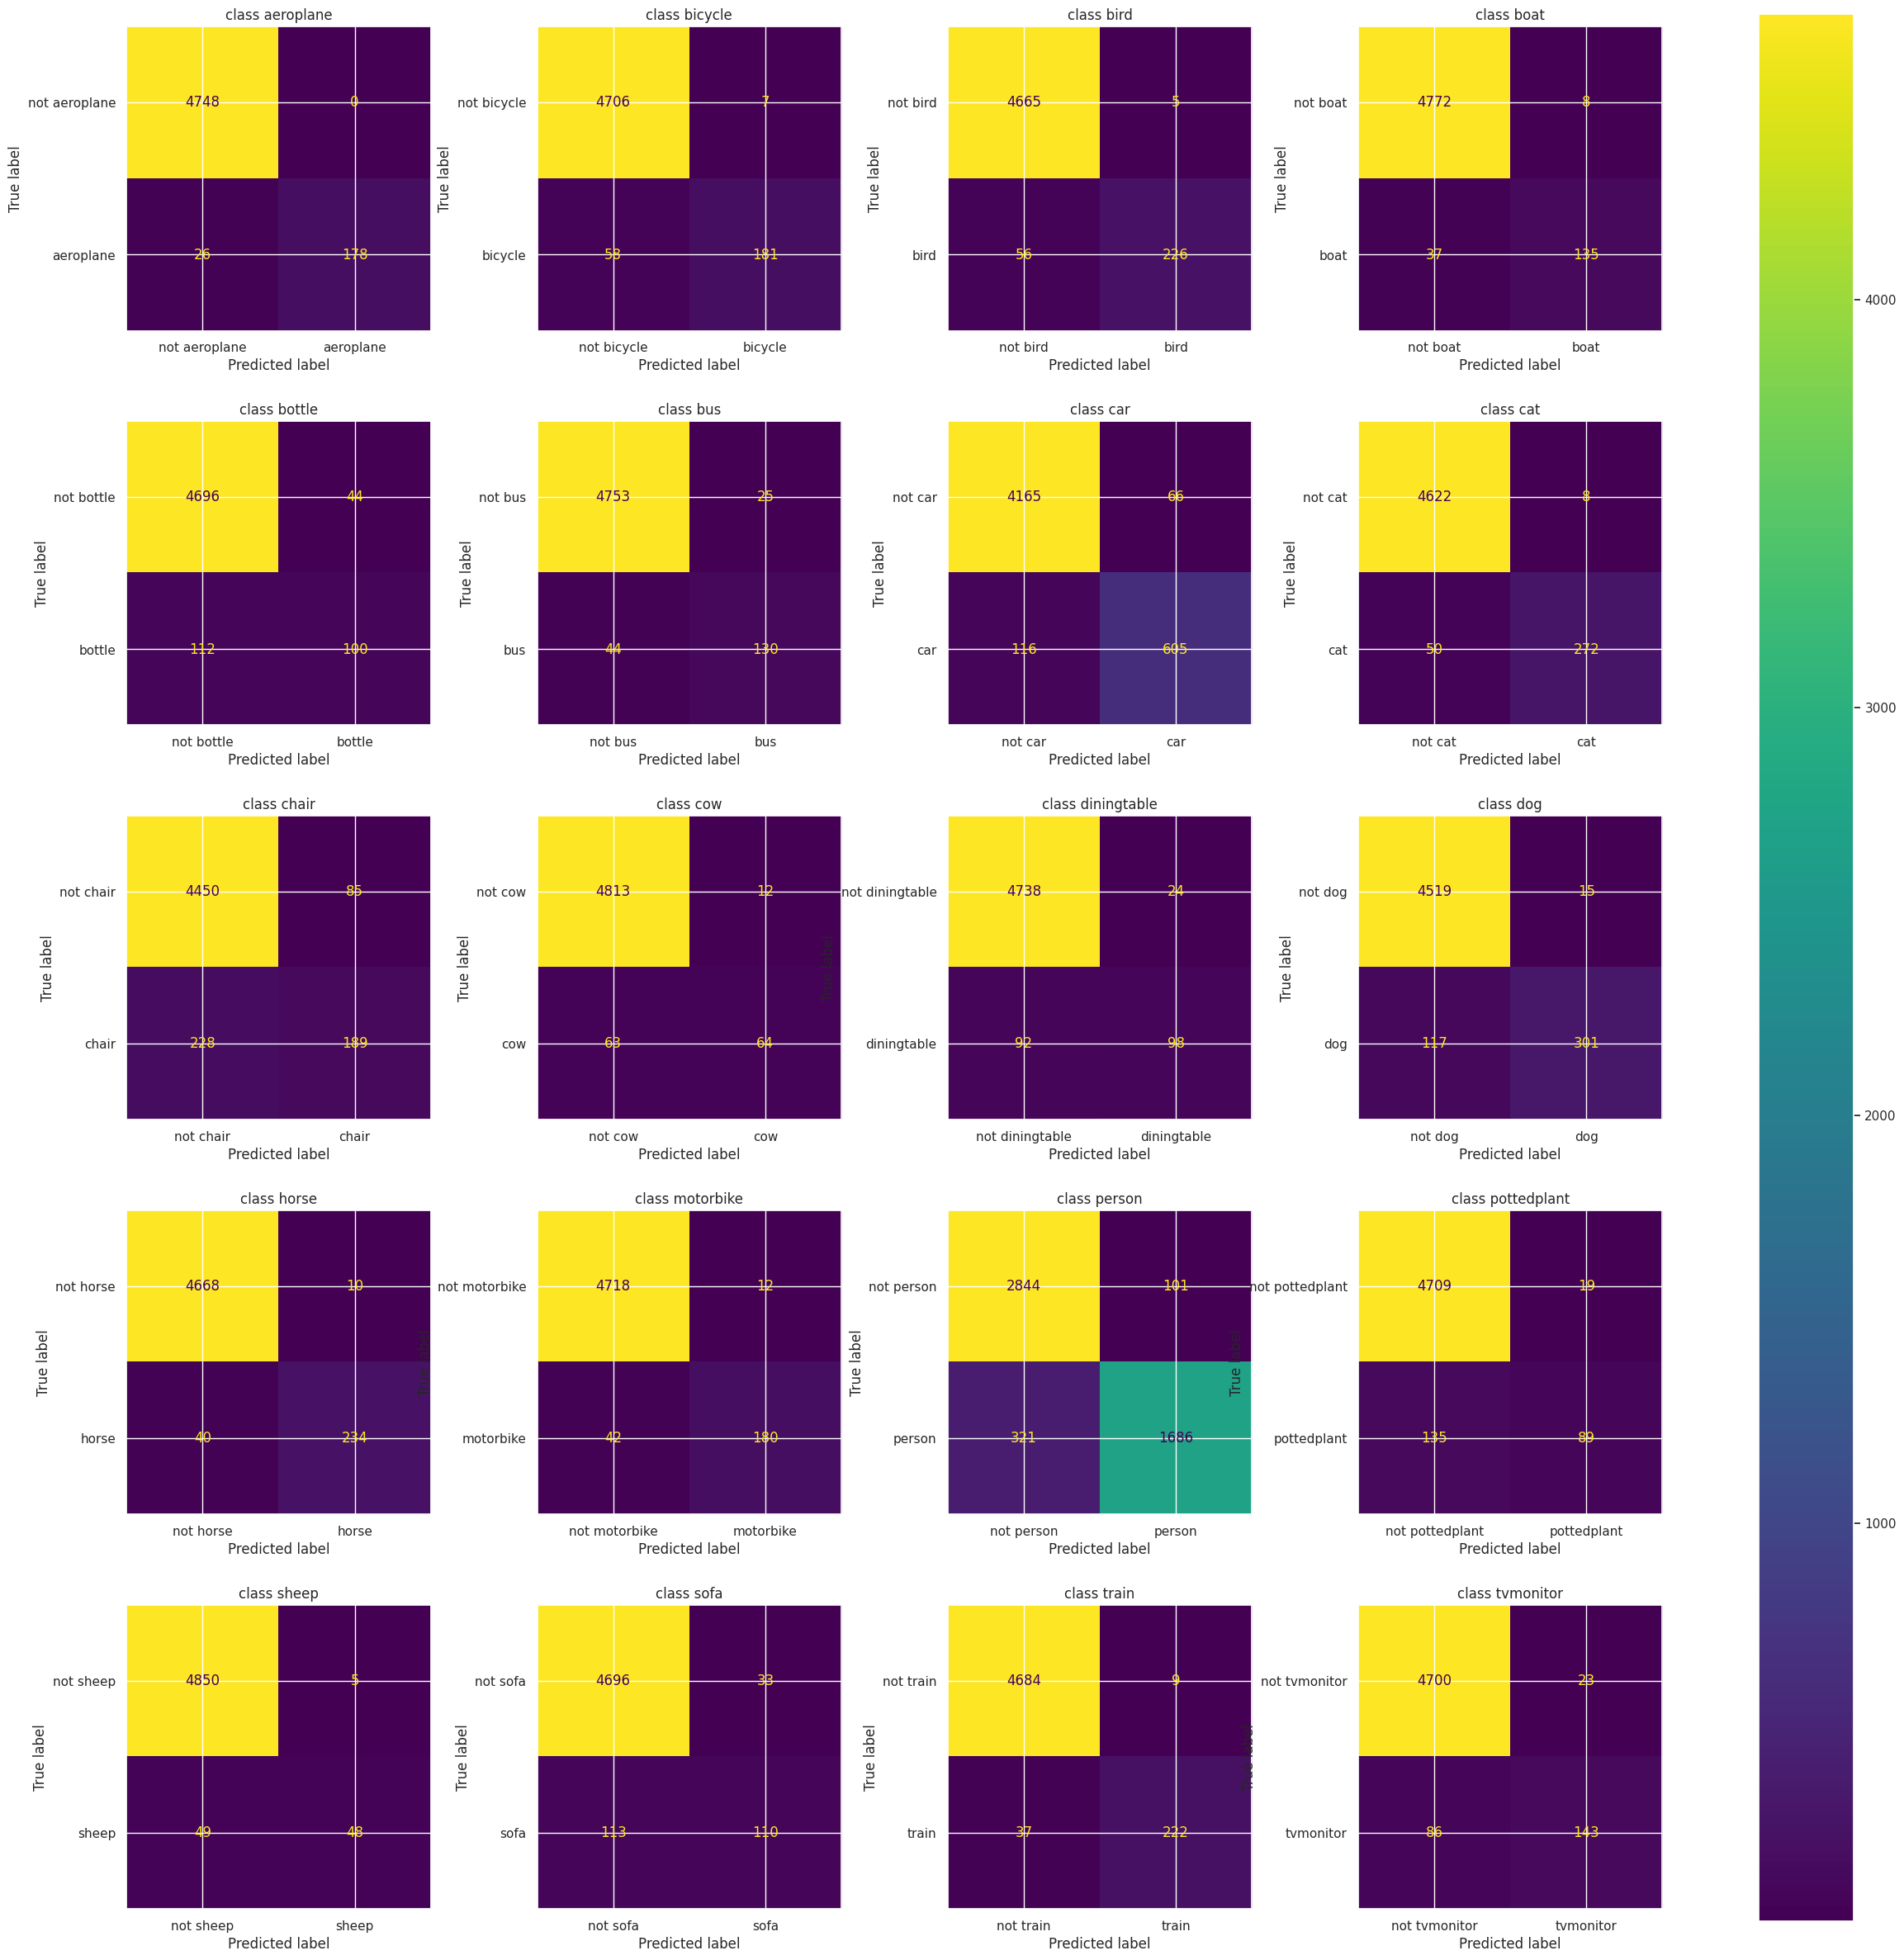

In [30]:
f, axes = plt.subplots(5, 4, figsize=(30, 30))
axes = axes.ravel()
for i in range(len(object_categories)):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_true_all)[:, i],
                                                   np.array(y_pred_all)[:, i]),
                                  display_labels=['not '+ object_categories[i], object_categories[i]])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {object_categories[i]}')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.35, hspace=0.2)
f.colorbar(disp.im_, ax=axes)
plt.show()